
# 📊 Advertising Campaign ROAS Optimizer

This notebook predicts **Return on Ad Spend (ROAS)** from advertising campaign data  
and provides optimization recommendations.

It is designed to be **modular and reusable** — simply change the parameters in the first section  
to adapt it for other datasets.

---


## 🔧 Parameters

In [1]:

# ===== PARAMETERS =====
DATA_PATH = r"C:\Users\ochib\Downloads\data-science-projects\advertising-roas-optimizer\data\advertising_campaign_data.csv"  # Path to dataset
TARGET_COLUMN = "roas"  # Target variable for prediction
CATEGORICAL_COLUMNS = ["audience_segment"]  # Columns to encode
MODEL_SAVE_PATH = "best_model.pkl"  # Where to save the best model

RANDOM_STATE = 42
TEST_SIZE = 0.2


## 📦 Imports

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import joblib

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


## 📥 Load Data

In [7]:

data = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {data.shape[0]} rows, {data.shape[1]} columns")
data.head()


Dataset loaded: 500 rows, 9 columns


,campaign_id,audience_segment,impressions,clicks,spend,conversions,ctr,revenue,roas
0,1,Segment_C,1190,2643,4841.73,291,222.100840,29100,6.010248
1,2,Segment_D,11492,4350,125.74,428,37.852419,53500,425.481152
2,3,Segment_A,36743,3868,605.16,102,10.527175,5100,8.427523
3,4,Segment_C,7102,4188,1641.52,474,58.969304,47400,28.875676
4,5,Segment_C,20778,3873,4056.41,267,18.639908,26700,6.582175


## 🔍 Exploratory Data Analysis (EDA)

,campaign_id,impressions,clicks,spend,conversions,ctr,revenue,roas
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,250.500000,25348.992000,2590.218000,2585.744800,252.564000,21.253921,22644.15000,20.265075
std,144.481833,13831.788882,1392.647182,1429.182526,145.769281,40.296244,15652.74101,47.249412
min,1.000000,1009.000000,53.000000,101.160000,2.000000,0.108400,250.00000,0.051869
25%,125.750000,13443.000000,1425.000000,1343.770000,130.000000,5.853990,10237.50000,4.121081
50%,250.500000,25079.500000,2644.000000,2677.535000,259.500000,10.322296,19350.00000,8.183843
75%,375.250000,37933.750000,3725.500000,3788.455000,381.250000,17.864079,33725.00000,16.708350
max,500.000000,49816.000000,4994.000000,4996.830000,499.000000,450.049554,62000.00000,539.150630


Missing values per column:
campaign_id         0
audience_segment    0
impressions         0
clicks              0
spend               0
conversions         0
ctr                 0
revenue             0
roas                0
dtype: int64


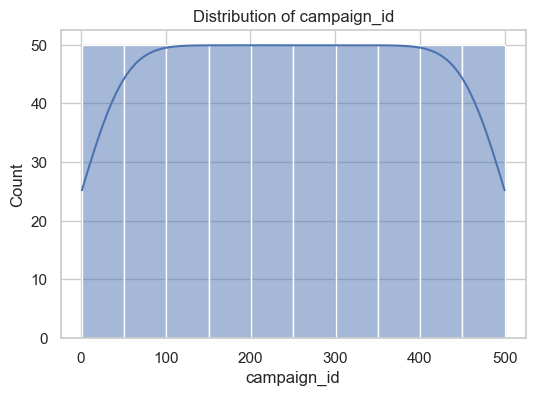

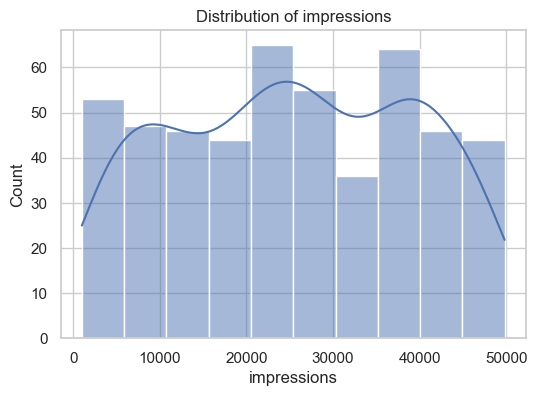

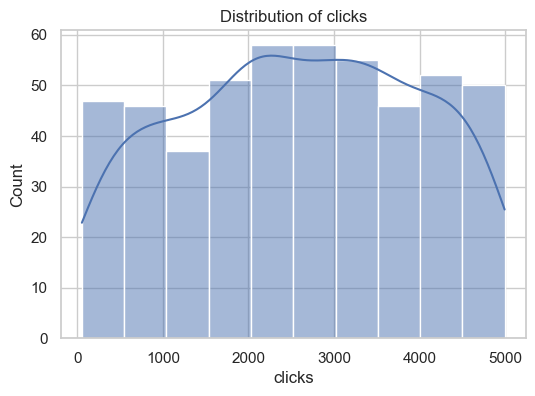

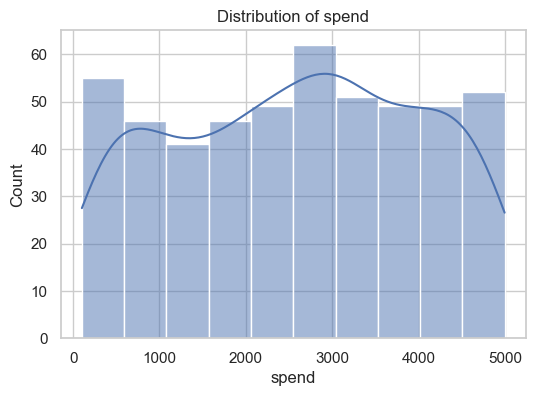

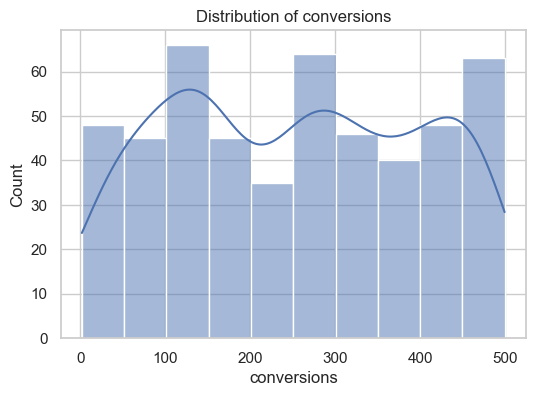

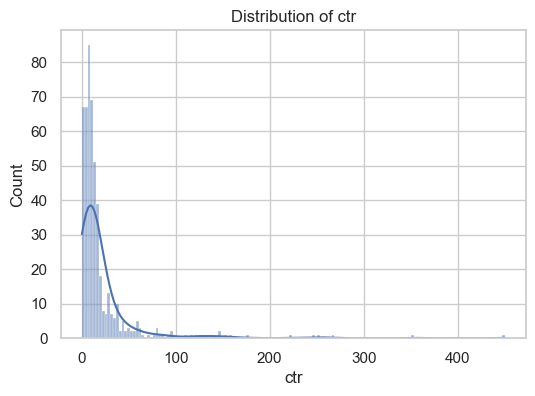

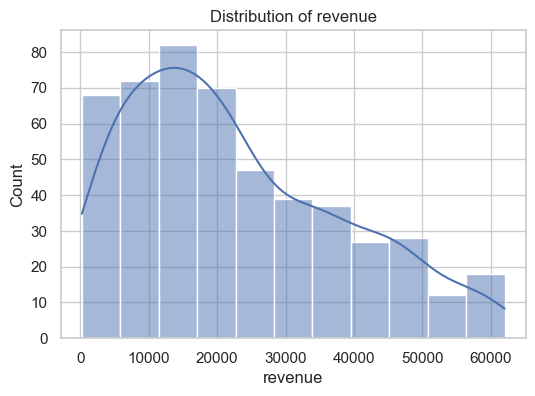

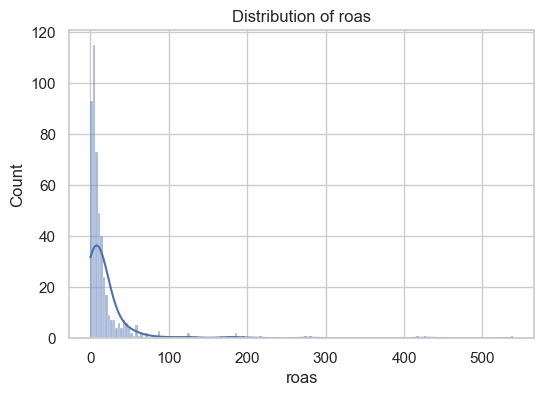

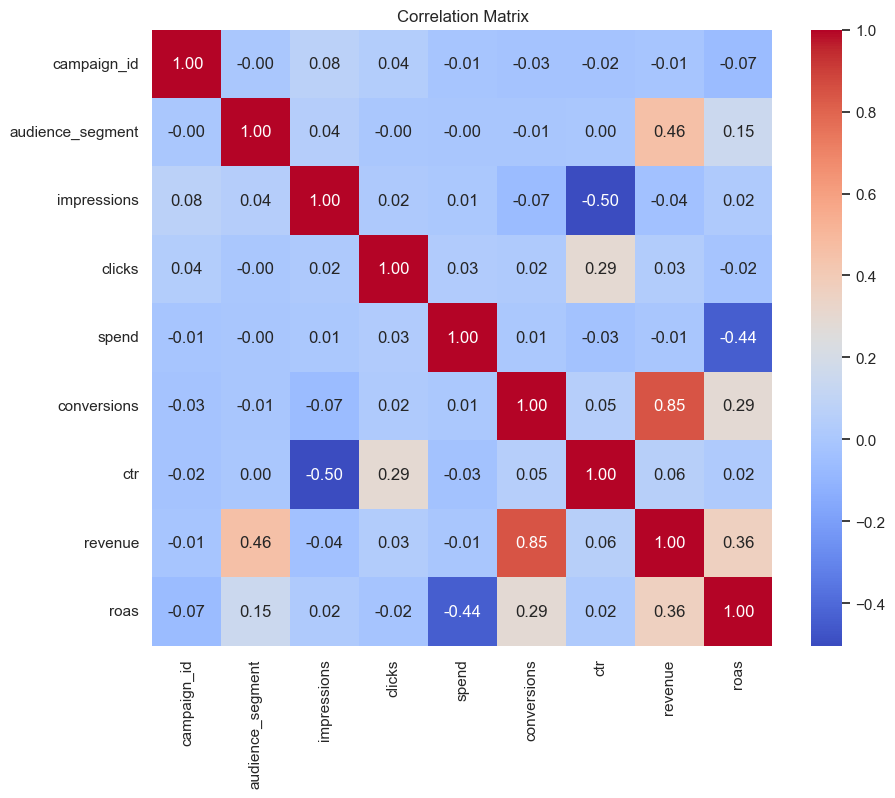

In [10]:

# Summary statistics
display(data.describe())

# Missing values
print("Missing values per column:")
print(data.isnull().sum())

# Univariate plots
for col in data.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Correlation matrix
data_encoded = data.copy()
for col in CATEGORICAL_COLUMNS:
    data_encoded[col] = data_encoded[col].astype("category").cat.codes

plt.figure(figsize=(10,8))
sns.heatmap(data_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


## 🛠 Preprocessing

In [13]:

def preprocess(df):
    df = df.copy()
    df = pd.get_dummies(df, columns=CATEGORICAL_COLUMNS, drop_first=True)
    return df

data_processed = preprocess(data)
X = data_processed.drop(TARGET_COLUMN, axis=1)
y = data_processed[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


## 🤖 Model Training & Evaluation

In [17]:

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=RANDOM_STATE),
    "XGBoost": XGBRegressor(random_state=RANDOM_STATE, objective="reg:squarederror")
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    results[name] = {"R2": r2, "MAE": mae}
    print(f"{name} → R2: {r2:.4f}, MAE: {mae:.4f}")

# Pick best model
best_model_name = max(results, key=lambda m: results[m]["R2"])
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
joblib.dump(best_model, MODEL_SAVE_PATH)


Linear Regression → R2: 0.2625, MAE: 19.8303
Random Forest → R2: 0.7933, MAE: 5.3432
XGBoost → R2: 0.8596, MAE: 4.6145
Best Model: XGBoost


['best_model.pkl']

## 📈 Prediction Demo

In [20]:

# Create example new data
new_data = data.sample(5, random_state=RANDOM_STATE).drop(TARGET_COLUMN, axis=1)
new_data_processed = preprocess(new_data)

# Ensure same columns as training
missing_cols = set(X.columns) - set(new_data_processed.columns)
for col in missing_cols:
    new_data_processed[col] = 0
new_data_processed = new_data_processed[X.columns]

# Predict
loaded_model = joblib.load(MODEL_SAVE_PATH)
predictions = loaded_model.predict(new_data_processed)

pd.DataFrame({
    "Input": new_data.to_dict(orient="records"),
    "Predicted ROAS": predictions
})


,Input,Predicted ROAS
0,"{'campaign_id': 362, 'audience_segment': 'Segm...",22.795094
1,"{'campaign_id': 74, 'audience_segment': 'Segme...",3.928341
2,"{'campaign_id': 375, 'audience_segment': 'Segm...",2.942652
3,"{'campaign_id': 156, 'audience_segment': 'Segm...",7.515359
4,"{'campaign_id': 105, 'audience_segment': 'Segm...",0.943716


In [24]:
import joblib
model = joblib.load("best_model.pkl")
print(type(model))

<class 'xgboost.sklearn.XGBRegressor'>
